In [1]:
#!g1.1
%load_ext autoreload
%autoreload 2

In [2]:
#!g1.1
import os
# to make torch.use_deterministic_algorithms(True) work
os.environ.update({'CUBLAS_WORKSPACE_CONFIG': ':4096:8'})

In [3]:
#!g1.1
from pathlib import Path
import random

import numpy as np
import pandas as pd
import torch


seed = 3407
_ = torch.manual_seed(seed)
rng = np.random.default_rng(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)

In [4]:
#!g1.1
from src.augmentations import DefaultWaveAugmentations, DefaultWave2Spec
from src.configs import DefaultConfig
from src.data_utils import get_dataloaders, SpeechCommandsDataset
from src.models import CRNN
from src.trainers import DefaultTrainer
from src.utils import count_parameters

In [5]:
#!g1.1
CHECKPOINT_PATH = Path('checkpoints/baseline.pth')
DATA_DIR = Path('data/speech_commands')
TRAIN_CSV = Path('data/train.csv')
VAL_CSV = Path('data/val.csv')

config = DefaultConfig()

In [6]:
#!g1.1
train_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(TRAIN_CSV))
train_set.transforms = DefaultWaveAugmentations(DATA_DIR)

val_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(VAL_CSV))
train_loader, val_loader = get_dataloaders(train_set, val_set, config.batch_size)

train_wave2spec = DefaultWave2Spec(is_train=True, config=config)
val_wave2spec = DefaultWave2Spec(is_train=False, config=config)

In [7]:
#!g1.1
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [8]:
#!g1.1
count_parameters(model)

70443

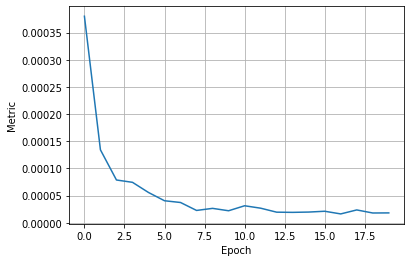

END OF EPOCH 20, val metric: 1.82129552175835e-05


[0.0003799776246803446,
 0.0001342220801945898,
 7.874179033290113e-05,
 7.446902626481798e-05,
 5.576076459800138e-05,
 4.056738845646547e-05,
 3.735088031024087e-05,
 2.2748291379236006e-05,
 2.655558673599167e-05,
 2.215750416870496e-05,
 3.1341559896051285e-05,
 2.6889769400534484e-05,
 1.9549685875754763e-05,
 1.9209535663630828e-05,
 1.974661494593178e-05,
 2.1244469388793332e-05,
 1.63451128246924e-05,
 2.366729370672875e-05,
 1.8039896337730968e-05,
 1.82129552175835e-05]

In [9]:
#!g1.1
trainer = DefaultTrainer(
    opt=torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay),
    train_loader=train_loader,
    val_loader=val_loader,
    device=config.device,
    model=model,
    train_wave2spec=train_wave2spec,
    val_wave2spec=val_wave2spec,
)
trainer.train(n_epochs=config.num_epochs)

In [10]:
#!g1.1
if not CHECKPOINT_PATH.parent.exists():
    CHECKPOINT_PATH.parent.mkdir()
torch.save(trainer.best_state, str(CHECKPOINT_PATH))

In [11]:
#!g1.1
trainer.best_score

1.63451128246924e-05

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: train_loader, trainer, val_loader
  warnings.warn(message)
